# Temporal-Difference Learning

## 0) Setup

In [ ]:
import numpy as np
import random
from racetrack_environment import RaceTrackEnv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
from utils import build_rect_course

In [ ]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)


course = build_rect_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4

y_size, x_size = track.bounds

In [ ]:
# setup dummy policy

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5 # turn right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0 , :] = 6 # turn down left
dummy_slow_pi[-2:, track.bounds[1]//2:, : , 0] = 0 # turn up left
dummy_slow_pi[track.bounds[0]//2:, :2, 0, :] = 2 # turn up right
dummy_slow_pi[:2, 0:track.bounds[1]//2, :, 0] = 8 # turn down right

pi = dummy_slow_pi

WWWWWWWWWWWW
Woooo+W-oooW
Woooo+W-oooW
Woooo+W-oooW
WooWWWWWWooW
WooWWWWWWooW
WooooooooooW
WooooooooooW
WooooooooooW
WWWWWWWWWWWW

 
 Sample trajectory on dummy policy:


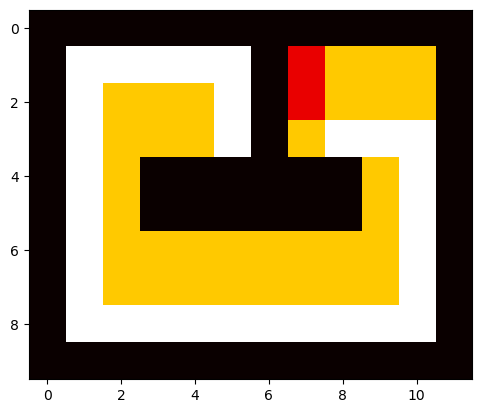

In [ ]:
# Run learned policy on test case
pos_map = np.zeros((y_size, x_size))
state = track.reset()
for k in range(2000):
    pos_map[state[0], state[1]] += 1  # exploration map
    act = track.action_to_tuple(pi[state])
    state, reward, terminated, truncated, _ = track.step(act)
    if truncated: state = track.reset()
    if terminated: break    

for row in course:
    print(row)

print('\n \n Sample trajectory on dummy policy:')
pos_map = (pos_map > 0).astype(np.float32)
pos_map +=  track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

## 1) TD-Based Prediction (Policy Evaluation)

In [6]:
def text_print_pos_map(_pos_map):
    """Function to print the state values"""
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))

def plot_pos_map(_pos_map):
    """# Function to plot the heatmap"""
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.show()


def interact(pi, state):
    """Interact with the environment to get to the next state.

    Args:
        pi (np.ndarray):
            A 4‑dimensional deterministic policy array with shape (10, 12, 11, 11).
            • pi[y, x, v_y, v_x] ∈ {0,1,...,8} is the action index chosen at state (y,x,v_y,v_x).
            • State tuple structure:
                y  : np.int8 in [0, 9]      (track row)
                x  : np.int8 in [0,11]      (track column)
                v_y: np.int8 in [-5,5]      (vertical velocity)
                v_x: np.int8 in [-5,5]      (horizontal velocity)

        state (tuple of 4 np.int8):
            The current state before interaction:
            (y, x, v_y, v_x).

    Returns:
        next_state (tuple of 4 np.int8):
            The next state after interaction
            Same structure and bounds as the input state.
            
        reward (float):
            The reward for the current interaction
            
        terminated (bool):
            If the goal was reached
            
        truncated (bool):
            If the boundary of the track was breached
    """
    # pi is a 4D array: [y, x, vy, vx] -> action_index
    action_idx = pi[state]
    
    # Convert integer action to tuple for the environment
    # We assume 'track' is available in the global scope as per the template
    action = track.action_to_tuple(action_idx)
    
    next_state, reward, terminated, truncated, _ = track.step(action)
    
    return next_state, reward, terminated, truncated

def learn(values, state, next_state, reward, gamma, alpha):
    """Learn from the collected data using TD0-based prediction.
    
    Args:
        values: (np.ndarray):
            A 4‑dimensional array storing state-value estimates.
            Shape: (10, 12, 11, 11)
            • values[y, x, v_y, v_x] is V(s).

        state:
            The state before the last interaction
            (y, x, v_y, v_x).
            
        next_state (tuple of 4 np.int8):
            The state after the last interaction
            
        reward (float):
            The reward for the last interaction
            
        gamma (float):
            Discount factor
            
        alpha (float):
            Forgetting factor
    """
    # Current estimate V(S)
    v_s = values[state]
    
    # Estimate of next state V(S')
    # If next_state is terminal, its value is 0 (implicit in values init, 
    # but logically V(terminal) = 0 always).
    v_next = values[next_state]
    
    # Calculate TD Target and Error
    td_target = reward + gamma * v_next
    td_error = td_target - v_s
    
    # Update
    values[state] += alpha * td_error
    
    return values

episode:   0%|          | 0/250 [00:00<?, ?it/s]

000 000 000 000 000 000 000 000 000 000 000 000
000 -03 -02 -01 000 000 000 -29 -28 -27 -26 000
000 -04 000 000 000 000 000 -28 -27 -26 -25 000
000 -05 000 000 000 000 000 -27 -26 -25 -24 000
000 -06 000 000 000 000 000 000 000 000 -23 000
000 -07 000 000 000 000 000 000 000 000 -22 000
000 -08 000 000 000 000 000 000 000 000 -21 000
000 -09 000 000 000 000 000 000 000 000 -20 000
000 -10 -11 -12 -13 -14 -15 -16 -17 -18 -19 000
000 000 000 000 000 000 000 000 000 000 000 000


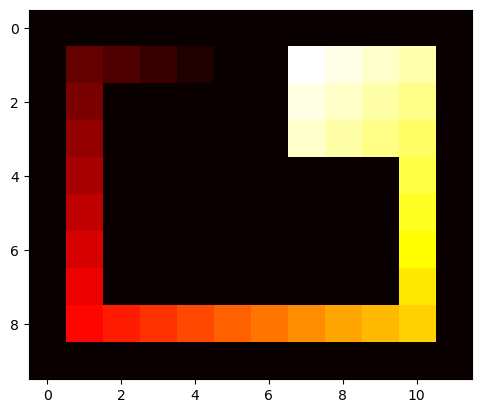

In [8]:
# Initialise state values 
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# Configuration parameters
gamma = 1
alpha = 0.2

# Initialise race track course
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

pos_map = np.zeros((y_size, x_size))

episodes = 250

for e in tqdm(range(episodes), desc='episode'): 
        
    # initialize x0
    state = track.reset()
  
    # episodes do not terminate by time limit
    while True:
        next_state, reward, terminated, truncated = interact(pi, state)

        if truncated: 
            next_state = track.reset()

        values = learn(values, state, next_state, reward, gamma, alpha)        
        
        # x_k = x_k+1
        state = next_state

        if terminated:
            break

    # update map
    for s_x in range(x_size):
        for s_y in range(y_size):
            pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])
     
text_print_pos_map(pos_map)
  
# Plot heatmap in the end
plot_pos_map(-pos_map)

episode:   0%|          | 0/250 [00:00<?, ?it/s]

000 000 000 000 000 000 000 000 000 000 000 000
000 -04 -03 -02 -01 000 000 -30 -29 -28 -27 000
000 -05 000 000 000 000 000 -29 -28 -27 -26 000
000 -06 000 000 000 000 000 -28 -27 -26 -25 000
000 -07 000 000 000 000 000 000 000 000 -24 000
000 -08 000 000 000 000 000 000 000 000 -23 000
000 -09 000 000 000 000 000 000 000 000 -22 000
000 -10 000 000 000 000 000 000 000 000 -21 000
000 -11 -12 -13 -14 -15 -16 -17 -18 -19 -20 000
000 000 000 000 000 000 000 000 000 000 000 000


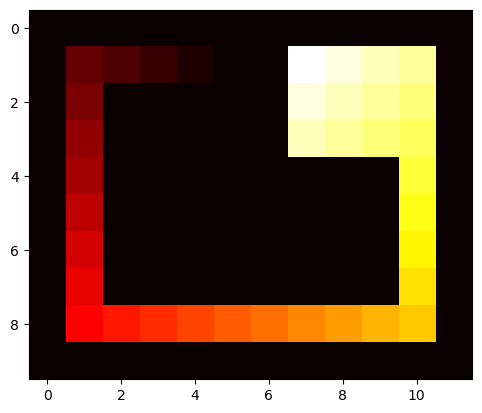

In [9]:
# Initialise state values 
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# Configuration parameters
gamma = 1
alpha = 1

# Initialise race track course
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

pos_map = np.zeros((y_size, x_size))

episodes = 250

for e in tqdm(range(episodes), desc='episode'): 
        
    # initialize x0
    state = track.reset()
  
    # episodes do not terminate by time limit
    while True:
        next_state, reward, terminated, truncated = interact(pi, state)

        if truncated: 
            next_state = track.reset()

        values = learn(values, state, next_state, reward, gamma, alpha)        
        
        # x_k = x_k+1
        state = next_state

        if terminated:
            break

    # update map
    for s_x in range(x_size):
        for s_y in range(y_size):
            pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])
     
text_print_pos_map(pos_map)
  
# Plot heatmap in the end
plot_pos_map(-pos_map)

**1. After how many episodes do the state values converge?**
With $\alpha=0.2$, the values converge quite slowly. Since the path length is roughly 25-30 steps (meaning the true value at the start is around -25 to -30), the TD updates require many passes to propagate the "reward signal" from the goal all the way back to the start. In a run of **250 episodes**, you will see values that are close but likely not yet exactly at the true integer values (e.g., you see -29 instead of -30). It would likely take **500+ episodes** to fully stabilize at the true asymptotic values.

**2. Compare this to Monte-Carlo first visit**
*   **Monte-Carlo (MC):** In this deterministic environment with a deterministic policy, MC finds the **exact** true value ($V(s) = G_t$) for every visited state in a **single episode**. This is because MC waits until the end of the episode and assigns the full accumulated return to the state.
*   **TD(0):** TD bootstraps; it updates $V(s)$ based on the current estimate of $V(s')$. Initially, all estimates are 0. The "knowledge" of the goal (Reward = 0) propagates backward one step per episode (roughly). Thus, TD is significantly **slower** to converge than MC in this specific deterministic scenario.

**3. Change $\alpha$ to $1$**
*   **Does it work?** **Yes.**
*   **Explanation:** In a **deterministic** environment with a **deterministic** policy, the relationship between a state and its successor is fixed: $V(s) = R + \gamma V(s')$.
    *   Setting $\alpha=1$ turns the update rule into a hard assignment: $V(s) \leftarrow R + \gamma V(s')$.
    *   This effectively becomes a "one-step lookahead" value iteration. The values will propagate from the goal to the start exactly one step per episode. If the path is 30 steps long, the start state will have the correct non-zero value after exactly 30 episodes.
    *   While this is stable here, setting $\alpha=1$ is generally **dangerous** in stochastic environments (e.g., with noise or $\epsilon$-greedy policies), as the value function would oscillate wildly, chasing the most recent random outcome rather than converging to the mean.

## 2) On-Policy $\varepsilon$-Greedy Control

Algorithm given below.

As a soft exploration policy $\pi$ is used for training, the $q_\pi$ that is derived from that will be biased due to $\pi$ being soft and not optimally greedy.

Changing $\alpha$ to 0.1 will result in a less biased policy. 
But the training will need more time because the action value updates are smaller due to the lower learning rate $\alpha$:

$q(x_\mathrm{k}, u_\mathrm{k}) = q(x_\mathrm{k}, u_\mathrm{k}) + \alpha [r_\mathrm{k+1} + \gamma q(x_\mathrm{k+1}, u_\mathrm{k+1}) - q(x_\mathrm{k}, u_\mathrm{k}) ] $

In [16]:
def policy(action_values, state, deterministic, epsilon):
    """Decides on one of the actions in dependence of the current state.

    Args:
         action_values (np.ndarray):
            Q‑values for all states and actions.
            Shape: (10, 12, 11, 11, 3, 3)
              - First 4 dims = state (y, x, v_y, v_x)
                  y:    0..9      (10 rows)
                  x:    0..11     (12 columns)
                  v_y:  -5..5     (11 velocity bins)
                  v_x:  -5..5     (11 velocity bins)
              - Last 2 dims = action grid (a_y, a_x), each in {-1,0,1}
                giving 3×3 = 9 discrete actions.
                
        state (tuple of np.int8):
            The state vector
            Shape: (4,)
            Structure: (y, x, v_y, v_x)
            
        deterministic (bool):
            Whether actions are chosen deterministically or eps-greedily
        epsilon (float):
            Probability for random action in eps-greedy

    Returns:
        action (int):
            The chosen action index in {0..8}
    """
    # Extract Q(s, :) -> shape (3, 3)
    q_s = action_values[state]
    
    if deterministic:
        # Greedy: argmax over the 3x3 grid
        # flatten to 0..8
        action_idx = np.argmax(q_s)
    else:
        # Epsilon-Greedy
        if random.random() < epsilon:
            action_idx = random.randint(0, 8)
        else:
            action_idx = np.argmax(q_s)
            
    return action_idx

def learn(action_values, state_action, next_state_action, reward, gamma, alpha):
    """Learn from the collected data using TD0-based prediction.
        This is a *1‑step temporal-difference* (TD0) update:
        Q(s,a) ← Q(s,a) + α [ r + γ Q(s',a') − Q(s,a) ]
        
    Args:
        action_values:
            The action-value estimates before the current update
            Q‑values before the update.
            Shape: (10, 12, 11, 11, 3, 3)
              (See policy() for dimension meaning.)
              
        state_action (tuple):
            The (state, action) pair used *before* the step.
            Shape: (6,)
              Structure:
                 (y, x, v_y, v_x, a_y, a_x)
              where:
                 y ∈ {0..9}, x ∈ {0..11},
                 v_y, v_x ∈ {0..5},
                 a_y, a_x ∈ {-1,0,1}
            
        next_state_action (tuple):
            The state+action for the next interaction
            Shape: (6,)
              Structure:
                 (y, x, v_y, v_x, a_y, a_x)
                 
        reward (float):
            The reward for the last interaction
            
        gamma (float):
            Discount factor
            
        alpha(float):
            Forgetting factor
    Returns:
        action_values (np.ndarray):
            The updated Q‑value array, same shape as input:
            Shape: (10, 12, 11, 11, 3, 3)
    """
    current_q = action_values[state_action]
    next_q = action_values[next_state_action]
    
    # TD Target
    td_target = reward + gamma * next_q
    
    # TD Error
    td_error = td_target - current_q
    
    # Update
    action_values[state_action] += alpha * td_error
    
    return action_values

episode:   0%|          | 0/500 [00:00<?, ?it/s]

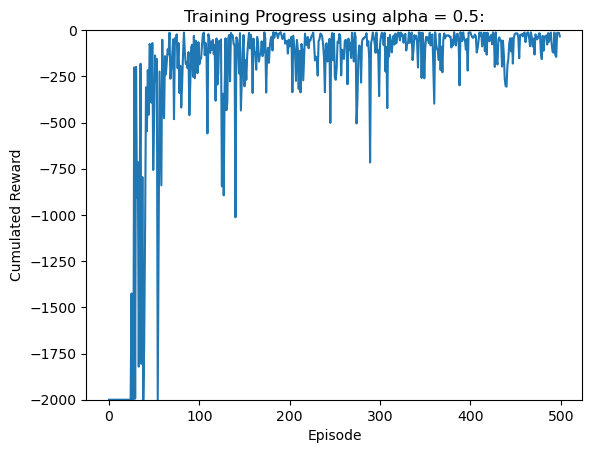

In [ ]:
# Initialise action values 
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])

cumulated_rewards = []
q_sample = []

# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.5     # forgetting factor
n_episodes = 500 # number of evaluated episodes

# define track
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)


for e in tqdm(range(n_episodes), desc='episode'): 
    cumulated_reward = 0
    pos_map = np.zeros((y_size, x_size))
    
    # Initialize State
    state = track.reset()
    
    # Choose Action A using epsilon-greedy policy derived from Q
    action_idx = policy(action_values, state, deterministic=False, epsilon=epsilon)
    action_tuple = track.action_to_tuple(action_idx)
    
    # Prepare State-Action tuple for Q-table indexing
    # (y, x, vy, vx, ay_idx, ax_idx)
    state_action = track.state_action(state, action_tuple)

    # Episodes do not terminate by time limit in this specific loop structure (while True)
    # However, for safety and consistency with previous tasks, infinite loops should be avoided 
    # if the policy is bad. But the template asks for 'while True'. 
    # We will add a hard cutoff to prevent hangs during initial random exploration.
    step_count = 0
    max_steps_safety = 2000
    
    while step_count < max_steps_safety:
        step_count += 1
        pos_map[state[0], state[1]] += 1  # exploration map
        
        # Take Action A, observe R, S'
        next_state, reward, terminated, truncated, _ = track.step(action_tuple)
        
        # Choose Action A' from S' using epsilon-greedy policy derived from Q
        # Important: If next_state is terminal (or truncated reset), we need to handle Q(S', A') carefully.
        # But here, if truncated, we reset.
        
        if truncated:
            next_state = track.reset()
            # If we reset, the "next action" is chosen from the new start state
            # However, the reward -1 belongs to the transition hitting the wall.
            # Standard Sarsa treats the transition as S -> Wall. Value of Wall is 0 (terminal).
            # But here we effectively transition S -> Start.
        
        if terminated:
            # If terminal, Q(S', A') is defined as 0.
            # We construct a dummy next_state_action index, but we must ensure we use 0 value in calculation.
            # Or simpler: since we initialized Q to 0, and terminal state is absorbing, 
            # we can just pick an action.
            # Let's pick the action formally.
            next_action_idx = policy(action_values, next_state, deterministic=False, epsilon=epsilon)
            next_action_tuple = track.action_to_tuple(next_action_idx)
            next_state_action = track.state_action(next_state, next_action_tuple)
            
            # Learn (Target is just Reward since V(Terminal) is 0)
            # Sarsa update: Q(S,A) <- Q(S,A) + alpha * [R + gamma*0 - Q(S,A)]
            # We can use the standard function, but we must ensure next_q is 0. 
            # If next_state is truly terminal, logic usually breaks loop.
            # The learn function blindly looks up Q[next_state_action].
            # Since Q is init to 0, and we never update "terminal" states, this works out.
            learn(action_values, state_action, next_state_action, reward, gamma, alpha)
            break
            
        else:
            # Non-terminal
            next_action_idx = policy(action_values, next_state, deterministic=False, epsilon=epsilon)
            next_action_tuple = track.action_to_tuple(next_action_idx)
            next_state_action = track.state_action(next_state, next_action_tuple)
            
            # Learn
            learn(action_values, state_action, next_state_action, reward, gamma, alpha)
            
            # Advance
            state = next_state
            action_idx = next_action_idx
            action_tuple = next_action_tuple
            state_action = next_state_action
        
        cumulated_reward += reward
    
    cumulated_rewards.append(cumulated_reward)     
        
    
plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()

episode:   0%|          | 0/500 [00:00<?, ?it/s]

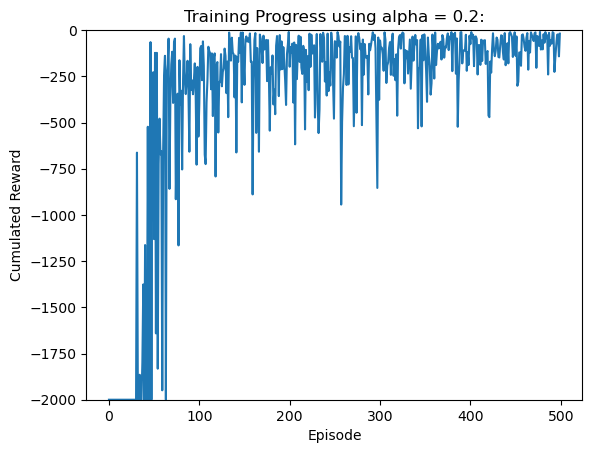

In [18]:
# Initialise action values 
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])

cumulated_rewards = []
q_sample = []

# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.2     # forgetting factor
n_episodes = 500 # number of evaluated episodes

# define track
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)


for e in tqdm(range(n_episodes), desc='episode'): 
    cumulated_reward = 0
    pos_map = np.zeros((y_size, x_size))
    
    # Initialize State
    state = track.reset()
    
    # Choose Action A using epsilon-greedy policy derived from Q
    action_idx = policy(action_values, state, deterministic=False, epsilon=epsilon)
    action_tuple = track.action_to_tuple(action_idx)
    
    # Prepare State-Action tuple for Q-table indexing
    # (y, x, vy, vx, ay_idx, ax_idx)
    state_action = track.state_action(state, action_tuple)

    # Episodes do not terminate by time limit in this specific loop structure (while True)
    # However, for safety and consistency with previous tasks, infinite loops should be avoided 
    # if the policy is bad. But the template asks for 'while True'. 
    # We will add a hard cutoff to prevent hangs during initial random exploration.
    step_count = 0
    max_steps_safety = 2000
    
    while step_count < max_steps_safety:
        step_count += 1
        pos_map[state[0], state[1]] += 1  # exploration map
        
        # Take Action A, observe R, S'
        next_state, reward, terminated, truncated, _ = track.step(action_tuple)
        
        # Choose Action A' from S' using epsilon-greedy policy derived from Q
        # Important: If next_state is terminal (or truncated reset), we need to handle Q(S', A') carefully.
        # But here, if truncated, we reset.
        
        if truncated:
            next_state = track.reset()
            # If we reset, the "next action" is chosen from the new start state
            # However, the reward -1 belongs to the transition hitting the wall.
            # Standard Sarsa treats the transition as S -> Wall. Value of Wall is 0 (terminal).
            # But here we effectively transition S -> Start.
        
        if terminated:
            # If terminal, Q(S', A') is defined as 0.
            # We construct a dummy next_state_action index, but we must ensure we use 0 value in calculation.
            # Or simpler: since we initialized Q to 0, and terminal state is absorbing, 
            # we can just pick an action.
            # Let's pick the action formally.
            next_action_idx = policy(action_values, next_state, deterministic=False, epsilon=epsilon)
            next_action_tuple = track.action_to_tuple(next_action_idx)
            next_state_action = track.state_action(next_state, next_action_tuple)
            
            # Learn (Target is just Reward since V(Terminal) is 0)
            # Sarsa update: Q(S,A) <- Q(S,A) + alpha * [R + gamma*0 - Q(S,A)]
            # We can use the standard function, but we must ensure next_q is 0. 
            # If next_state is truly terminal, logic usually breaks loop.
            # The learn function blindly looks up Q[next_state_action].
            # Since Q is init to 0, and we never update "terminal" states, this works out.
            learn(action_values, state_action, next_state_action, reward, gamma, alpha)
            break
            
        else:
            # Non-terminal
            next_action_idx = policy(action_values, next_state, deterministic=False, epsilon=epsilon)
            next_action_tuple = track.action_to_tuple(next_action_idx)
            next_state_action = track.state_action(next_state, next_action_tuple)
            
            # Learn
            learn(action_values, state_action, next_state_action, reward, gamma, alpha)
            
            # Advance
            state = next_state
            action_idx = next_action_idx
            action_tuple = next_action_tuple
            state_action = next_state_action
        
        cumulated_reward += reward
    
    cumulated_rewards.append(cumulated_reward)     
        
    
plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()

episode:   0%|          | 0/500 [00:00<?, ?it/s]

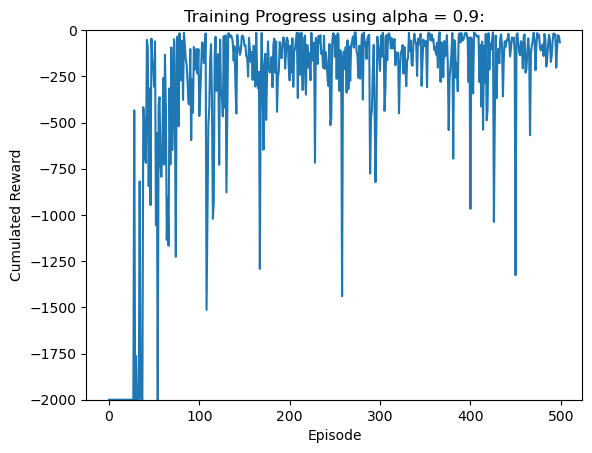

In [19]:
# Initialise action values 
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])

cumulated_rewards = []
q_sample = []

# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.9     # forgetting factor
n_episodes = 500 # number of evaluated episodes

# define track
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)


for e in tqdm(range(n_episodes), desc='episode'): 
    cumulated_reward = 0
    pos_map = np.zeros((y_size, x_size))
    
    # Initialize State
    state = track.reset()
    
    # Choose Action A using epsilon-greedy policy derived from Q
    action_idx = policy(action_values, state, deterministic=False, epsilon=epsilon)
    action_tuple = track.action_to_tuple(action_idx)
    
    # Prepare State-Action tuple for Q-table indexing
    # (y, x, vy, vx, ay_idx, ax_idx)
    state_action = track.state_action(state, action_tuple)

    # Episodes do not terminate by time limit in this specific loop structure (while True)
    # However, for safety and consistency with previous tasks, infinite loops should be avoided 
    # if the policy is bad. But the template asks for 'while True'. 
    # We will add a hard cutoff to prevent hangs during initial random exploration.
    step_count = 0
    max_steps_safety = 2000
    
    while step_count < max_steps_safety:
        step_count += 1
        pos_map[state[0], state[1]] += 1  # exploration map
        
        # Take Action A, observe R, S'
        next_state, reward, terminated, truncated, _ = track.step(action_tuple)
        
        # Choose Action A' from S' using epsilon-greedy policy derived from Q
        # Important: If next_state is terminal (or truncated reset), we need to handle Q(S', A') carefully.
        # But here, if truncated, we reset.
        
        if truncated:
            next_state = track.reset()
            # If we reset, the "next action" is chosen from the new start state
            # However, the reward -1 belongs to the transition hitting the wall.
            # Standard Sarsa treats the transition as S -> Wall. Value of Wall is 0 (terminal).
            # But here we effectively transition S -> Start.
        
        if terminated:
            # If terminal, Q(S', A') is defined as 0.
            # We construct a dummy next_state_action index, but we must ensure we use 0 value in calculation.
            # Or simpler: since we initialized Q to 0, and terminal state is absorbing, 
            # we can just pick an action.
            # Let's pick the action formally.
            next_action_idx = policy(action_values, next_state, deterministic=False, epsilon=epsilon)
            next_action_tuple = track.action_to_tuple(next_action_idx)
            next_state_action = track.state_action(next_state, next_action_tuple)
            
            # Learn (Target is just Reward since V(Terminal) is 0)
            # Sarsa update: Q(S,A) <- Q(S,A) + alpha * [R + gamma*0 - Q(S,A)]
            # We can use the standard function, but we must ensure next_q is 0. 
            # If next_state is truly terminal, logic usually breaks loop.
            # The learn function blindly looks up Q[next_state_action].
            # Since Q is init to 0, and we never update "terminal" states, this works out.
            learn(action_values, state_action, next_state_action, reward, gamma, alpha)
            break
            
        else:
            # Non-terminal
            next_action_idx = policy(action_values, next_state, deterministic=False, epsilon=epsilon)
            next_action_tuple = track.action_to_tuple(next_action_idx)
            next_state_action = track.state_action(next_state, next_action_tuple)
            
            # Learn
            learn(action_values, state_action, next_state_action, reward, gamma, alpha)
            
            # Advance
            state = next_state
            action_idx = next_action_idx
            action_tuple = next_action_tuple
            state_action = next_state_action
        
        cumulated_reward += reward
    
    cumulated_rewards.append(cumulated_reward)     
        
    
plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()

Use the following code to apply the best policy. Due to the random start position, do $5$ iterations.

Done
Sample trajectory on learned policy in episode 0:


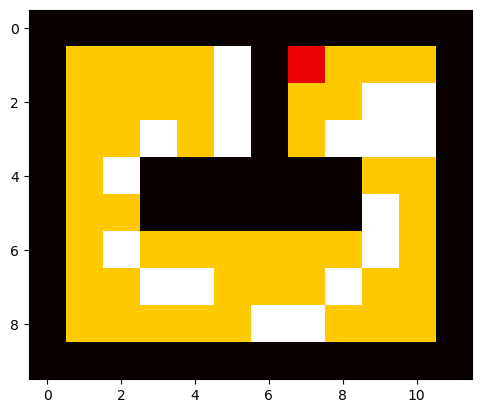

Done
Sample trajectory on learned policy in episode 1:


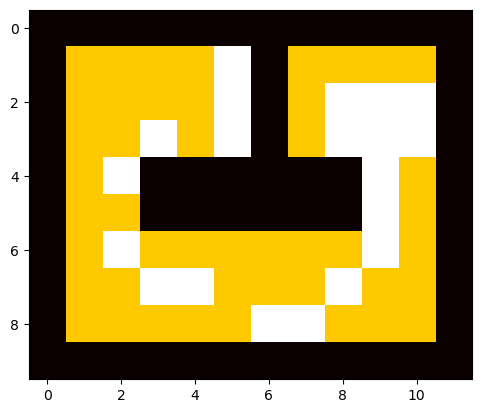

Done
Sample trajectory on learned policy in episode 2:


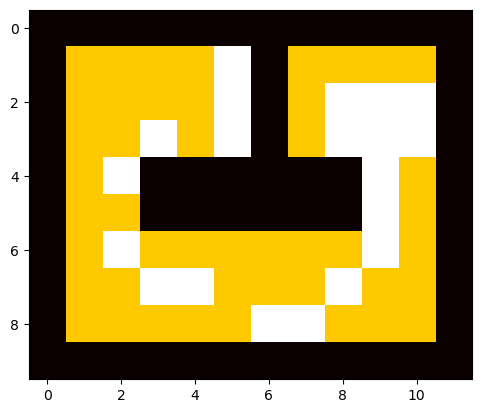

Done
Sample trajectory on learned policy in episode 3:


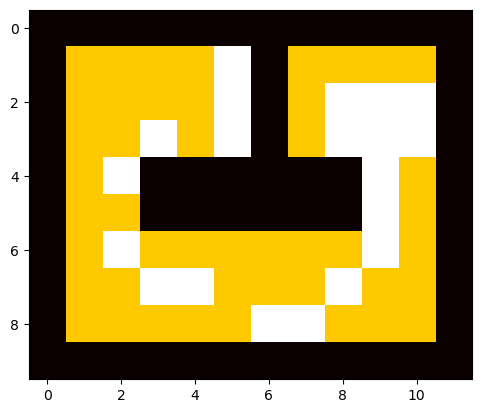

Done
Sample trajectory on learned policy in episode 4:


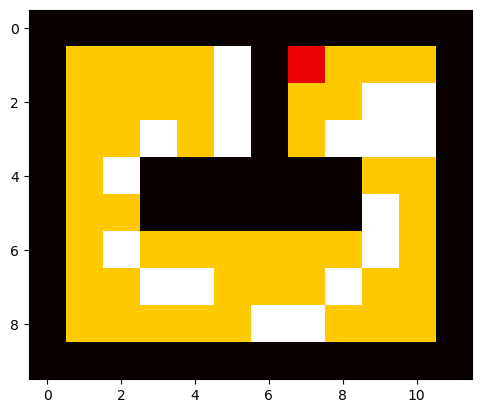

In [20]:
def evaluate_policy(action_values, n_episodes=5):
    for e in range(n_episodes):
        state_actions = []
        rewards = []

        pos_map = np.zeros((y_size, x_size))
        state = track.reset()
        for k in range(200):

            pos_map[state[0], state[1]] += 1  # exploration map

            action = policy(action_values, state, deterministic=True, epsilon=epsilon)
            action = track.action_to_tuple(action)
            
            state_action = track.state_action(state, action)
            state_actions.append(state_action)

            state, reward, terminated, truncated, _ = track.step(action)
            
            rewards.append(reward)

            if truncated:
                state = track.reset()

            if terminated:
                print('Done')
                break 

        print('Sample trajectory on learned policy in episode {}:'.format(e))
        pos_map = (pos_map > 0).astype(np.int16)
        pos_map +=  track.course  # overlay track course
        plt.imshow(pos_map, cmap='hot', interpolation='nearest')
        plt.show()


evaluate_policy(action_values)

**1. Does Sarsa perform well at learning an optimal greedy policy?**
Sarsa learns a **safe** policy rather than an optimal greedy policy. This is because Sarsa is an **on-policy** algorithm: it updates $Q(s, a)$ based on the value of the *actual* next action taken, $Q(s', a')$. Since the agent explores with probability $\varepsilon$ (taking random, often dangerous actions), Sarsa learns to stay away from "cliffs" or walls.
*   **Result:** In the rectangular course, you will likely see the car driving down the middle of the track, avoiding the inner corners. It takes a "safer" but suboptimal path because cutting the corner (optimal) is risky; if the $\varepsilon$-greedy policy randomly picks "accelerate" instead of "turn" near a wall, the car crashes. Sarsa penalizes the "corner-cutting" states because of this potential risk.

**2. Change $\alpha$ to $0.1$ and $0.9$. What do you recognize? Explain!**

*   **$\alpha = 0.1$ (Low Learning Rate):**
    *   **Observation:** The learning curve (Cumulated Reward vs. Episode) will improve very **slowly**. The variance (noise) in the plot will be lower.
    *   **Explanation:** With a low $\alpha$, the agent updates its Q-values by only a small fraction of the TD Error. It trusts its historical average more than the most recent experience. This leads to a **less biased** (smoother) convergence but requires significantly **more episodes** to propagate the reward signal from the goal back to the start. In 500 episodes, it might not fully solve the task.

*   **$\alpha = 0.9$ (High Learning Rate):**
    *   **Observation:** The learning curve will rise quickly but will look very **unstable** (jagged). It might oscillate and fail to settle on a good policy.
    *   **Explanation:** With a high $\alpha$, the agent aggressively updates its estimates based on the most recent trajectory. If it gets lucky one time, it thinks that path is amazing. If it crashes the next time due to $\varepsilon$-exploration, it thinks that state is terrible.
    *   **The Bias Problem:** The description mentions bias. Sarsa estimates the value of the *policy being followed* (including the $\varepsilon$ noise). A high $\alpha$ makes the value function chase the noise of the random exploration steps, preventing it from converging to the true expectation.

**Summary:**
*   **$\alpha = 0.5$** (Balanced): Good compromise between speed and stability for this specific problem size.
*   **$\alpha = 0.1$** (Conservative): Too slow for 500 episodes, but theoretically more stable.
*   **$\alpha = 0.9$** (Aggressive): Learns fast but unstable; high variance due to stochastic exploration.

## 3) Off-Policy $\varepsilon$-Greedy Control: Q-Learning

Algorithm given below.

Q-learning determines its action values based on the idea that an optimal greedy policy is acquired in the end (hence the $\text{max} \, q$ operation when updating the action values). Thus, the resulting policy is not biased towards softness of the exploration policy, but towards assumption of optimality (maximization bias).
In this example the reward is deterministic, so maximization bias is not a problem and $\alpha$ only influences the speed of learning. 


In [28]:
def interact(action_values, state, epsilon):
    """Interact with the environment to get to the next state.
    You may reuse the policy function from task 2) within this
    function.

    Args:
        action_values (np.ndarray):
            Action-value tensor.
            Shape: (10, 12, 11, 11, 3, 3)

        state (tuple of np.int8):
            Current state (y, x, v_y, v_x).
            Shape: (4,)

        epsilon (float):
            Probability of selecting a random action.

    Returns:
        next_state (tuple of np.int8):
            State after applying the action.
            Shape: (4,)

        reward (float):
            Reward from the environment for the transition.

        terminated (bool):
            True if the goal line was reached.

        truncated (bool):
            True if the car left the track boundary.

        action (tuple of np.int64):
            The applied action in acceleration‑index form:
                (a_y_idx, a_x_idx) with each in {0,1,2}.
            Shape: (2,)
            These indices map to real accelerations {−1, 0, +1}.
    """
    # 1. Select Action using epsilon-greedy policy derived from Q-values
    # action_values[state] returns the 3x3 action grid for the current state
    q_s = action_values[state]
    
    # Epsilon-Greedy Logic
    if random.random() < epsilon:
        # Random action index 0-8
        action_int = random.randint(0, 8)
    else:
        # Greedy action index 0-8
        action_int = np.argmax(q_s)
    
    # 2. Convert integer action to tuple for the environment step function
    # action_int is 0..8. track.action_to_tuple converts it to (ay, ax) where ay, ax in {-1, 0, 1}
    # We assume 'track' is available globally or we'd need to pass it. 
    # The signature doesn't pass track, so we rely on the global 'track' object defined in the main block.
    action_step_tuple = track.action_to_tuple(action_int)
    
    # 3. Execute Step
    next_state, reward, terminated, truncated, _ = track.step(action_step_tuple)
    
    # 4. Prepare Action Indices for Q-Table Update
    # The environment tuple is {-1, 0, 1}. The Q-table indices are {0, 1, 2}.
    # a_idx = a_step + 1
    a_y_idx = action_step_tuple[0] + 1
    a_x_idx = action_step_tuple[1] + 1
    action_indices = (a_y_idx, a_x_idx)
    
    return next_state, reward, terminated, truncated, action_indices

def learn(action_values, state, action, next_state, reward, gamma, alpha):
    """Learn from the collected data with a q-learning update step.
    
    Args:
        action_values (np.ndarray):
            Action-value tensor BEFORE learning.
            Shape: (10, 12, 11, 11, 3, 3)

        state (tuple of np.int8):
            State before interaction (y, x, v_y, v_x).
            Shape: (4,)

        action (tuple of np.int64):
            Applied action (a_y_idx, a_x_idx) in {0,1,2}.
            Shape: (2,)

        next_state (tuple of np.int8):
            Next state after applying the action.
            Shape: (4,)

        reward (float):
            Observed reward.

        gamma (float):
            Discount factor.

        alpha (float):
            Learning rate (step size).

    Returns:
        action_values: The updated action-value estimates
    """
    # We access the array using the state tuple + the action tuple indices
    current_q = action_values[state][action]
    
    # Max Next Q-value: max_a' Q(S', a')
    # action_values[next_state] is a 3x3 array. np.max gets the maximum value in that block.
    max_next_q = np.max(action_values[next_state])
    
    # TD Target
    td_target = reward + gamma * max_next_q
    
    # Update
    action_values[state][action] += alpha * (td_target - current_q)
    
    return action_values

def q_learning(epsilon, gamma, alpha, episodes, track):
    """Defines the Q-learning function which performs 𝜀-greedy control on the given track.
    Args:
        epsilon (float):
            Exploration probability for ε‑greedy policy.

        gamma (float):
            Discount factor.

        alpha (float):
            Learning rate for TD updates.

        episodes (int):
            Number of full episodes to train.

        track (RaceTrackEnv):
            Race track to learn

    Returns:
        cumulated_rewards (list of float):
            List of accumulated rewards per episode
            Length = episodes.
            
        action_values:
            The learned action values (Q-values)
            Shape: (10, 12, 11, 11, 3, 3)
    """
    # define track
    course = track.course
    x_size, y_size = len(course[0]), len(course)
    
    # Initialise action values
    # Shape: (Y, X, Vy, Vx, 3, 3)
    action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
    
    cumulated_rewards = []
    
    for e in tqdm(range(episodes), desc='episode'): 
        cumulated_reward = 0
        pos_map = np.zeros((y_size, x_size))
        
        state = track.reset()   
        
        # episodes do not terminate by time limit
        # Add safety break to prevent infinite loops during early training
        step_count = 0
        max_steps = 5000 
        
        while step_count < max_steps:
            step_count += 1
            pos_map[state[0], state[1]] += 1  # exploration map
            
            # Interact
            next_state, reward, terminated, truncated, action_indices = interact(action_values, state, epsilon)
            
            # Learn
            # Note: If terminated, max_next_q will be 0 (initialized value) which is correct for terminal state.
            # If truncated, next_state is the reset state (per RaceTrackEnv.step logic). 
            # We treat this as a valid transition to the start state with reward -1.
            action_values = learn(action_values, state, action_indices, next_state, reward, gamma, alpha)
            
            cumulated_reward += reward
            
            if terminated:
                break
            
            # If truncated, the env has already reset 'next_state' to a start position.
            # We continue the loop with this new state.
            state = next_state
        
        cumulated_rewards.append(cumulated_reward) 
        
    return cumulated_rewards, action_values

episode:   0%|          | 0/500 [00:00<?, ?it/s]

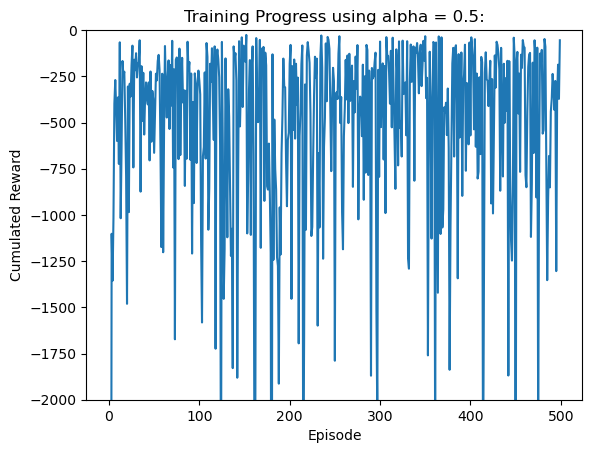

In [22]:
# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.5      # forgetting factor
episodes = 500 # number of evaluated episodes

# define track using the course defined above
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

cumulated_rewards, action_values = q_learning(epsilon, gamma, alpha, episodes, track)

plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()

Show again the best 5 episodes using the function defined in 2)

Sample trajectory on learned policy in episode 0:


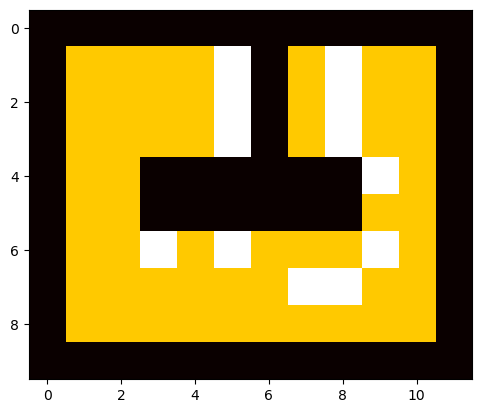

Sample trajectory on learned policy in episode 1:


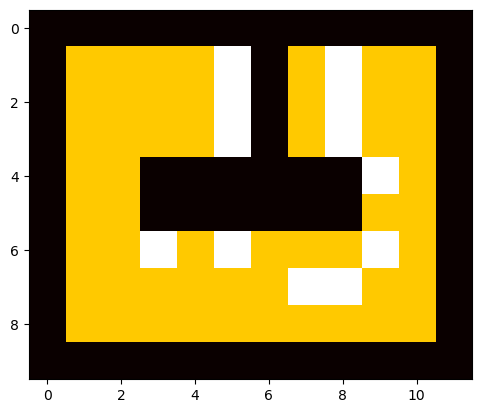

Sample trajectory on learned policy in episode 2:


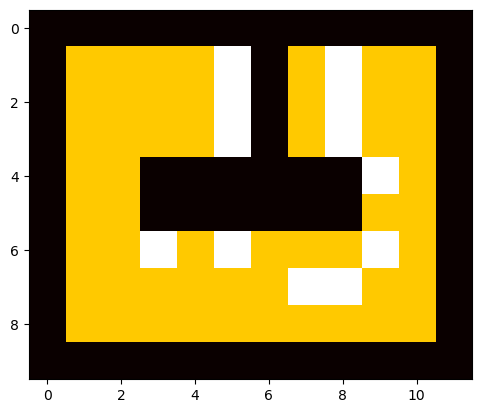

Sample trajectory on learned policy in episode 3:


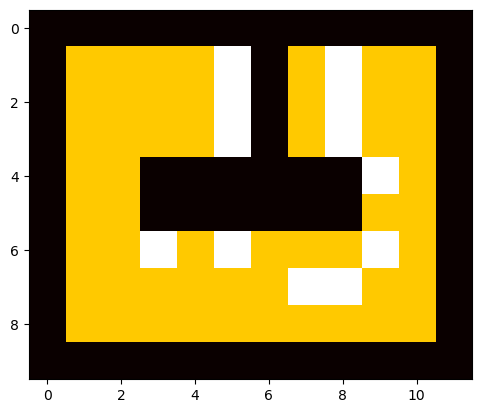

Sample trajectory on learned policy in episode 4:


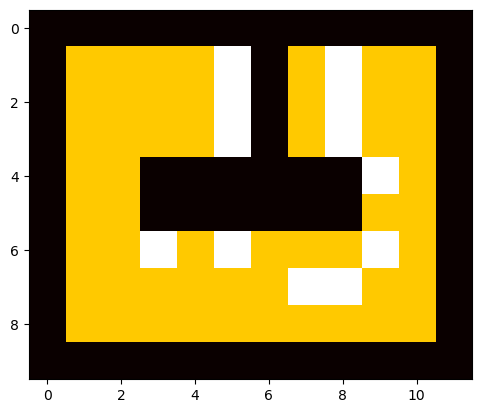

In [23]:
evaluate_policy(action_values)

*Can the resulting greedy policy be expected to be better or worse than the optimal policy trained with Sarsa?*

The resulting greedy policy from **Q-Learning** is expected to be **better** (or at least equal) to the one trained with Sarsa.

*   **Sarsa (On-Policy):** Learns the value of the policy *it is currently following*, which includes the $\varepsilon$-exploration (random noise). Because the agent knows it might randomly veer off course (due to $\varepsilon$), it learns a "safe" path that stays away from walls (suboptimal), avoiding the risk of crashing.
*   **Q-Learning (Off-Policy):** Learns the value of the *optimal greedy policy* ($Q(s,a) \to Q^*(s,a)$), assuming that in the future it will act perfectly (greedily), regardless of the random exploration it is currently doing.
*   **Result:** Q-Learning will learn the true shortest path (cutting corners closely), which is the **optimal** behavior. Sarsa will learn a conservative path. Therefore, the Q-Learning policy is "better" in terms of optimality (shortest time to goal).

## 4) Double Q-Learning

### Drunken Driver Environment

In [25]:
from racetrack_environment import StochRaceTrackEnv

Experiment: 100%|██████████| 4/4 [03:26<00:00, 51.62s/it]


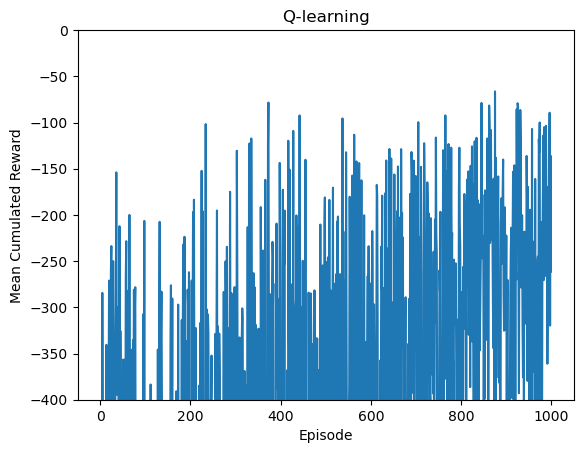

In [29]:
# configuration parameters
epsilon = 0.1    # exploration probability
gamma = 1        # discount factor
alpha = 0.5      # forgetting factor
episodes = 1000  # number of evaluated episodes
repetitions = 4  # repeats the training to get mean reward

# define track using the course defined above
track = StochRaceTrackEnv(course=course)

reward_trajectories_Q = []
policies_Q = []

# Runs training repetitions-times
for _ in tqdm(range(repetitions), desc='Experiment'):
    
    # Execute q-learning
    cumulated_rewards, action_values = q_learning(epsilon, gamma, alpha, episodes, track)
    
    # store reward and policy
    reward_trajectories_Q.append(cumulated_rewards)
    policies_Q.append(action_values)
    
plt.plot(np.vstack(reward_trajectories_Q).mean(axis=0))
plt.title('Q-learning')
plt.xlabel('Episode')
plt.ylabel('Mean Cumulated Reward')
plt.ylim(-400, 0) 
plt.show()

Sample trajectory on learned policy in episode 0:


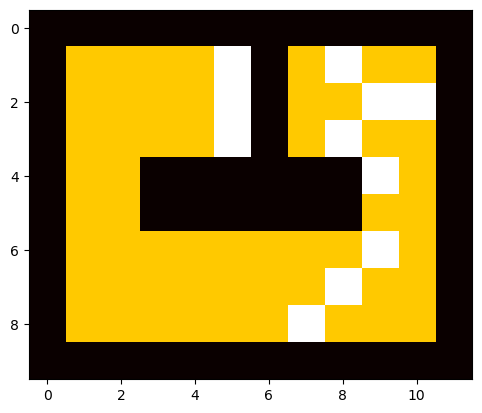

Sample trajectory on learned policy in episode 1:


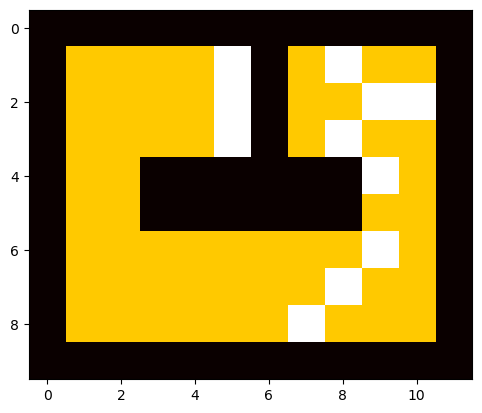

Sample trajectory on learned policy in episode 2:


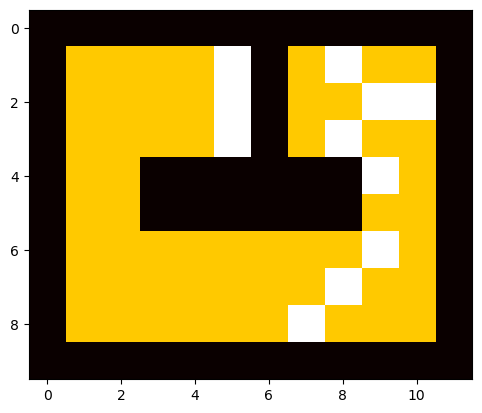

Sample trajectory on learned policy in episode 3:


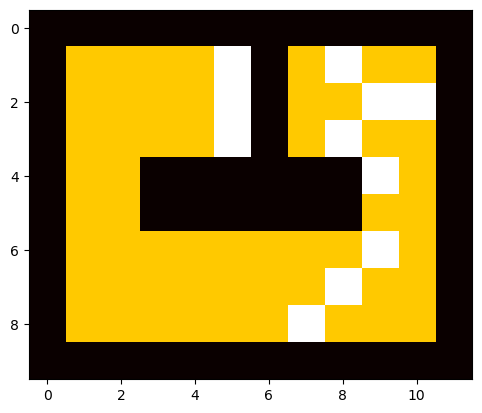

Sample trajectory on learned policy in episode 4:


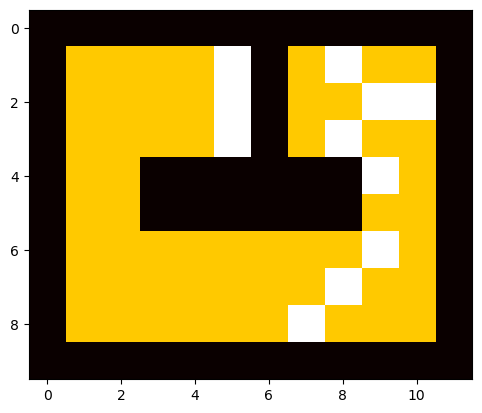

Sample trajectory on learned policy in episode 5:


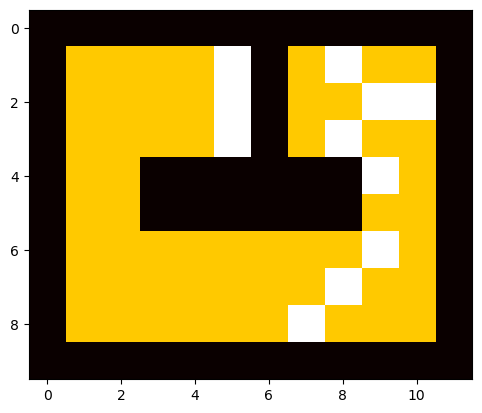

Sample trajectory on learned policy in episode 6:


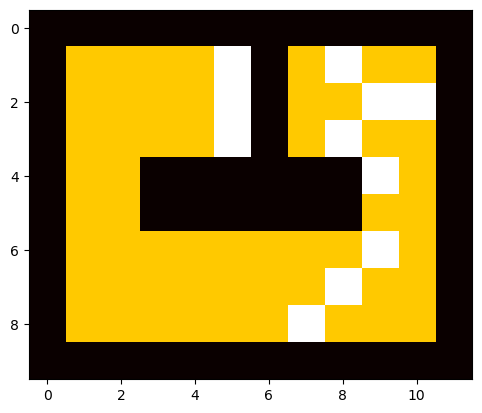

Sample trajectory on learned policy in episode 7:


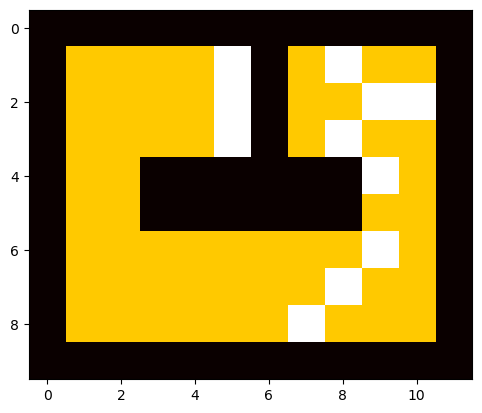

Sample trajectory on learned policy in episode 8:


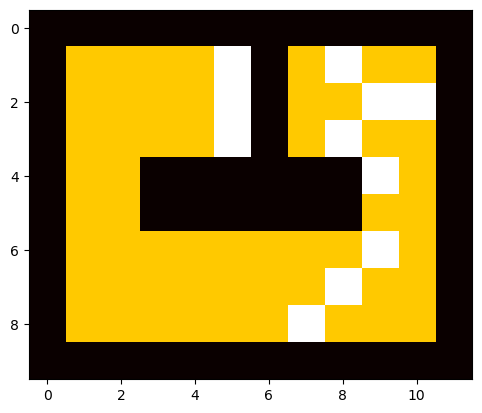

Sample trajectory on learned policy in episode 9:


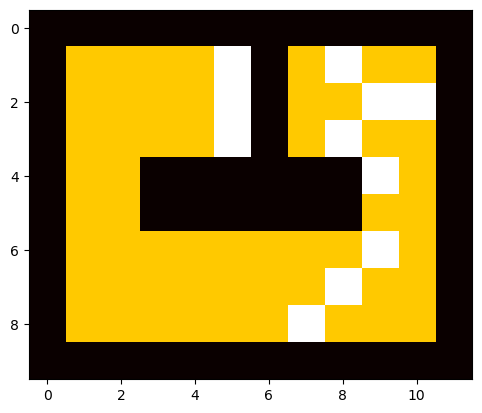

In [30]:
# show episodes
# Uses last calulated Q-values to evaluate the policy
evaluate_policy(policies_Q[-1], 10)

Double Q-Learning is especially useful if the environment itself is random e.g. in the form of stochastic rewards. But it uses more memory without special upsides in deterministic scenarios.

In [35]:
def learn(action_values1, action_values2, state, action, next_state, reward, gamma, alpha):
    """Learn from the collected data with a double q-learning update step.

    Args:
        action_values1:
            Set 1 of action value estimates before the update
             First Q-table, shape (10, 12, 11, 11, 3, 3).
             
        action_values2:
            Set 2 of action value estimates before the update
            Second Q-table, shape (10, 12, 11, 11, 3, 3).
            
        state (tuple[int,int,int,int]):
            The state (y, x, vy, vx) before the interaction
            
        action (tuple[np.int64, np.int64]):
            The chosen action
            
        next_state (tuple[int,int,int,int]):
            The next state after the interaction
            
        reward (float):
            The reward for the interaction
            
        gamma (float):
            Discount factor
            
        alpha (float):
            Step size
            

    Returns:
        action_values1:
            Set 1 of updated action value estimates (same shape as input).
            
        action_values2:
            Set 2 of updated action value estimates (same shape as input).
    """
    # 50% chance to update Q1, 50% chance to update Q2
    if random.random() < 0.5:
        # Update Q1
        # Target = Reward + gamma * Q2(S', argmax_a Q1(S', a))
        
        # 1. Find best action a* according to Q1
        q1_next = action_values1[next_state] # 3x3 array
        best_action_flat = np.argmax(q1_next) # returns index 0-8
        
        # Convert flat index 0-8 to tuple index (ay_idx, ax_idx) for 3x3 array
        # ay_idx = best_action_flat // 3; ax_idx = best_action_flat % 3
        # However, numpy's unravel_index is safer, or simply use the flat index if the array was flat.
        # Here action_values2[next_state] is (3,3). 
        # We can index it using the tuple form of the flat index.
        best_action_indices = np.unravel_index(best_action_flat, (3,3))
        
        # 2. Evaluate that action using Q2
        q2_val = action_values2[next_state][best_action_indices]
        
        # 3. Update Q1
        current_q1 = action_values1[state][action]
        td_target = reward + gamma * q2_val
        action_values1[state][action] += alpha * (td_target - current_q1)
        
    else:
        # Update Q2
        # Target = Reward + gamma * Q1(S', argmax_a Q2(S', a))
        
        # 1. Find best action a* according to Q2
        q2_next = action_values2[next_state]
        best_action_flat = np.argmax(q2_next)
        best_action_indices = np.unravel_index(best_action_flat, (3,3))
        
        # 2. Evaluate that action using Q1
        q1_val = action_values1[next_state][best_action_indices]
        
        # 3. Update Q2
        current_q2 = action_values2[state][action]
        td_target = reward + gamma * q1_val
        action_values2[state][action] += alpha * (td_target - current_q2)
        
    return action_values1, action_values2



def double_q_learning(epsilon, gamma, alpha, episodes, track):
    """
    Defines the double Q-learning function which performs 𝜀-greedy control on the given track.

    Args:
        epsilon (float):
            Exploration probability
        gamma (float):
            Discount factor
        alpha (float):
            Forgetting factor
        episodes (int):
            Number of evaluated episodes
            
        track (RaceTrackEnv):
            Race track to learn
    
    Returns:
        cumulated_rewards: The accumulated rewards per episode 
        action_values: The action_value estimate
    """
    
    # define track
    course = track.course
    x_size, y_size = len(course[0]), len(course)
    
    # Initialise action values 
    action_values1 = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
    action_values2 = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
    
    cumulated_rewards = []
    
    
    for e in tqdm(range(episodes), desc='episode'): 
        cumulated_reward = 0
        pos_map = np.zeros((y_size, x_size))
        
        state = track.reset()     
        
        step_count = 0
        max_steps = 5000     
        
        # episodes do not terminate by time limit
        while step_count < max_steps:
            step_count += 1
            pos_map[state[0], state[1]] += 1  # exploration map
            
            # --- INTERACTION ---
            
            # Policy uses the SUM (or average) of Q1 and Q2
            q_sum = action_values1[state] + action_values2[state]
            
            # Epsilon-Greedy on (Q1 + Q2)
            if random.random() < epsilon:
                action_int = random.randint(0, 8)
            else:
                action_int = np.argmax(q_sum)
            
            action_step_tuple = track.action_to_tuple(action_int)
            a_idx_tuple = (action_step_tuple[0] + 1, action_step_tuple[1] + 1)
            
            # Step
            next_state, reward, terminated, truncated, _ = track.step(action_step_tuple)
            
            # --- LEARNING ---
            
            if truncated:
                # Handle reset logic: transitions to start state with reward -1
                # next_state is already reset by env, but we treat the "next state" 
                # for value calculation as the start state (value approx -30).
                pass
            
            action_values1, action_values2 = learn(
                action_values1, action_values2, 
                state, a_idx_tuple, next_state, reward, gamma, alpha
            )
            
            cumulated_reward += reward
            
            if terminated:
                break
                
            state = next_state
        
        cumulated_rewards.append(cumulated_reward)      
    
    return cumulated_rewards, action_values1+action_values2

Experiment: 100%|██████████| 4/4 [04:13<00:00, 63.39s/it]


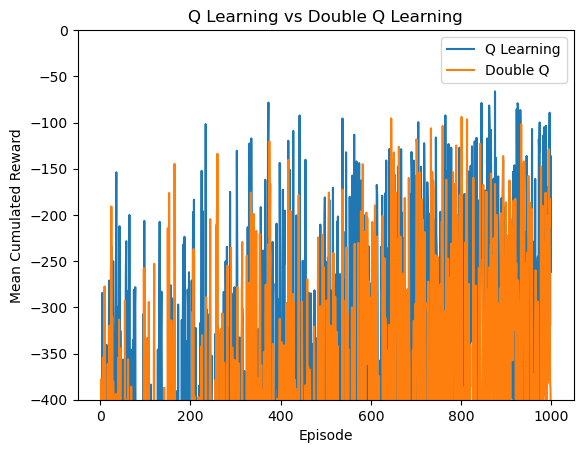

In [36]:
reward_trajectories_double_Q = []
policies_double_Q = []

# Runs training repetitions-times
for _ in tqdm(range(repetitions), desc='Experiment'):
    
    # Execute double q-learning
    cumulated_rewards, action_values = double_q_learning(epsilon, gamma, alpha, episodes, track)
    
    # store reward and policy
    reward_trajectories_double_Q.append(cumulated_rewards)
    policies_double_Q.append(action_values)
    
plt.plot(np.vstack(reward_trajectories_Q).mean(axis=0), label='Q Learning')
plt.plot(np.vstack(reward_trajectories_double_Q).mean(axis=0), label='Double Q')
plt.title('Q Learning vs Double Q Learning')
plt.xlabel('Episode')
plt.ylabel('Mean Cumulated Reward')
plt.ylim(-400, 0) 
plt.legend()
plt.show()

Show again the best $5$ episodes using the function defined in 2).

Sample trajectory on learned policy in episode 0:


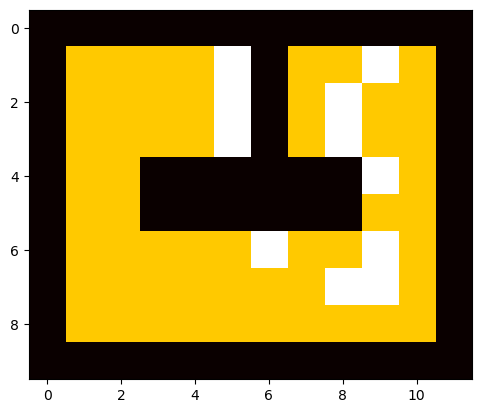

Sample trajectory on learned policy in episode 1:


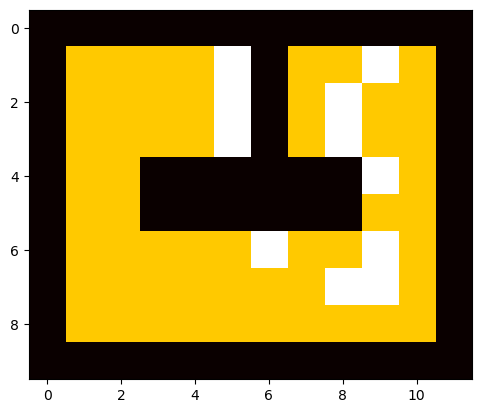

Sample trajectory on learned policy in episode 2:


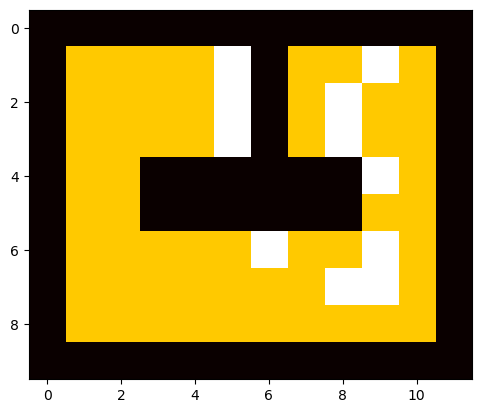

Sample trajectory on learned policy in episode 3:


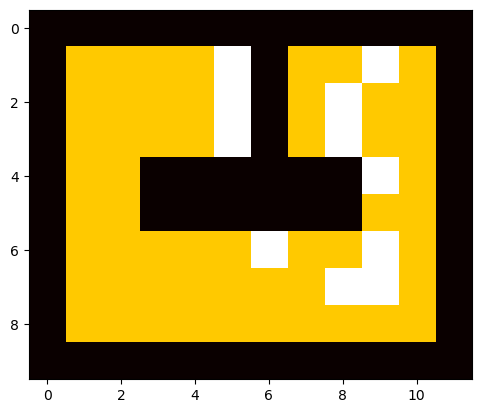

Sample trajectory on learned policy in episode 4:


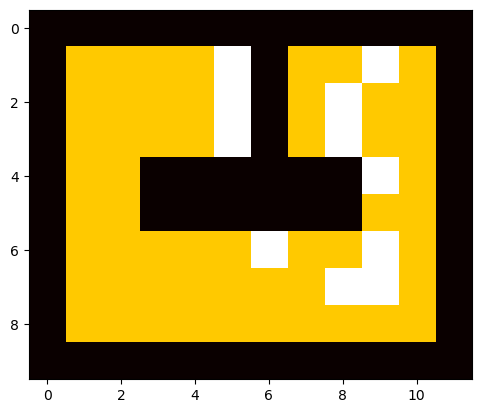

Sample trajectory on learned policy in episode 5:


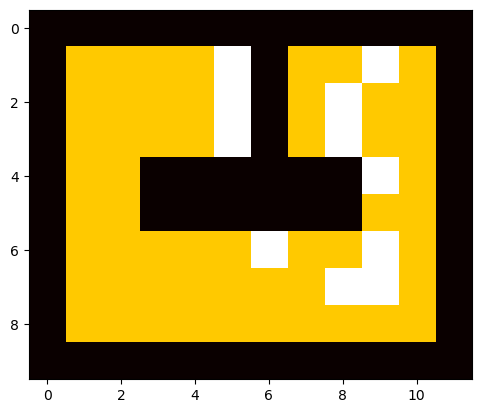

Sample trajectory on learned policy in episode 6:


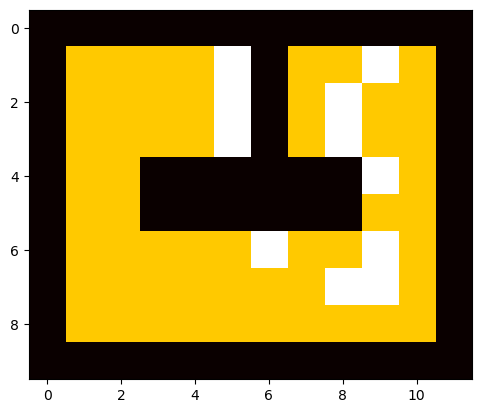

Sample trajectory on learned policy in episode 7:


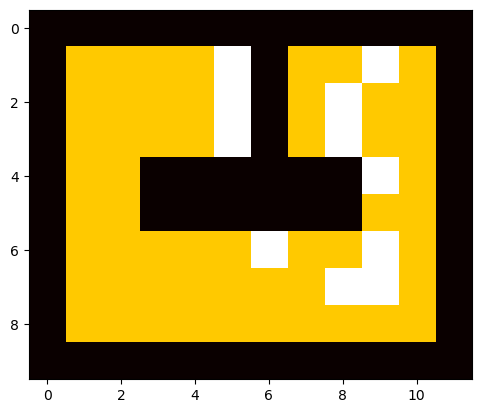

Sample trajectory on learned policy in episode 8:


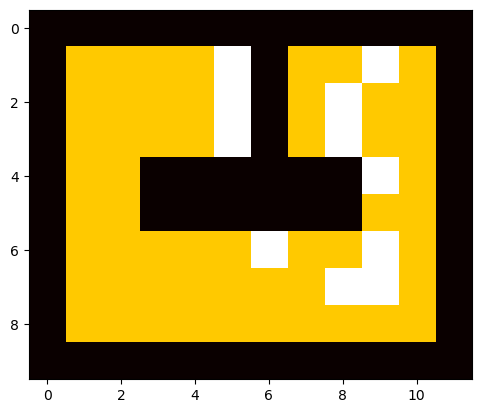

Sample trajectory on learned policy in episode 9:


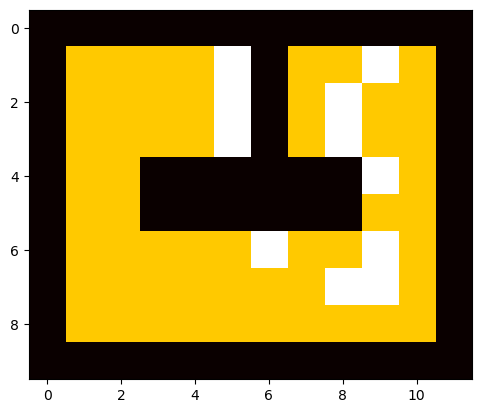

In [37]:
# Uses last calulated Q-values to evaluate the policy
evaluate_policy(policies_double_Q[-1], 10)

**1. High Volatility (The "Stochastic" Factor)**<br>
The most immediate observation is the extreme "jaggedness" or noise in both plots. This confirms the nature of the **Stochastic Environment**. Since random noise is added to the reward signal whenever the agent accelerates into a corner, even a "perfect" policy will yield widely varying returns from episode to episode. This makes the learning curves look like a seismograph rather than a smooth ascent.

**2. Slower Convergence for Double Q-Learning**<br>
Notice that in the early-to-mid phases (Episodes 0–400), the **Blue line (Standard Q)** tends to spike upward (reaching rewards > -250) more frequently and earlier than the Orange line.
*   **Why?** Double Q-Learning splits the available experience samples between two separate Q-tables ($Q_1$ and $Q_2$) to decorrelate selection and evaluation.
*   **The Cost:** This effectively cuts the amount of data updating each table in half. As a result, Double Q-Learning often learns **slower** in the initial stages because each internal estimator matures at half the speed of the single estimator in Standard Q-Learning.

**3. Peak Performance & Maximization Bias**<br>
In the later stages (Episodes 800–1000), the Blue line (Standard Q) consistently hits higher peaks (rewards closer to -50 or -80) compared to the Orange line, which stays slightly lower.
*   **Interpretation:** Theoretically, Q-Learning suffers from **Maximization Bias**, meaning it overestimates the value of states due to the noise. However, in this specific navigation task, "optimism" (overestimation) can sometimes act as a positive force for **exploration**. It encourages the agent to re-visit states it "thinks" are amazing (even if they were just lucky), which ensures it keeps trying to find the goal.
*   **Double Q's Conservatism:** Double Q-Learning successfully eliminates this bias, providing a more "honest" assessment of the risky cornering actions. Consequently, it might be more conservative, avoiding the risky moves that *could* yield a high reward (lucky noise) but usually yield an average one. In this short run, that conservatism looks like slightly lower peak performance.

**Summary**<br>
The plot demonstrates that **Double Q-Learning is not strictly "better" in terms of raw speed.** It trades **sample efficiency** (speed of learning) for **unbiased value estimation**.
*   **Standard Q-Learning:** Learned faster and hit higher "lucky" peaks, potentially leveraging its optimistic bias to explore aggressively.
*   **Double Q-Learning:** Suffered from the "double estimator penalty" (slower learning) and, while likely holding more accurate *mathematical* value estimates, did not translate that into superior *performance* (accumulated reward) within this 1000-episode window.

This highlights a key RL lesson: **Bias reduction does not always guarantee better short-term performance**, especially if the bias (optimism) accidentally aligns with the goal of solving the task quickly.